In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import MDAnalysis as mda

from mdvcontainment import Containment
import mdvcontainment.composition_logic as cl

import warnings
warnings.filterwarnings("ignore")

In [2]:
vmd = "/Applications/VMD\ 1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh"

# Loading and voxelizing the PCD

In [3]:
# Systems
settings = {}
settings['complex3D'] = ('../structures/complex3D.gro',  'name True', 1, '', False) # Artificial grid
settings['vesicle'] = ('../structures/vesicle.gro',  'name [CD][234][AB]', 0.5, 'de', False) # CG Martini
settings['transfection'] = ('../structures/transfection.gro',  'name [CD][234][AB]', 0.5, 'de', False) # CG Martini

# Settings
no_mapping = False
betafactors = True
verbose = False
selected_settings = 'transfection'
gro, selection_string, resolution, morph, slab= settings[selected_settings]

In [4]:
u = mda.Universe(gro)
selection = u.select_atoms(selection_string)

# Running an example

In [5]:
# Running the containment calculation
containment = Containment(
    selection, resolution=resolution, morph=morph, 
    slab=slab, max_offset=0.05, write_structures=False, 
    no_mapping=no_mapping, betafactors=betafactors, 
    verbose=verbose)

# Show the containment
print(containment)

Writing component ids in the tempfactors of universe.
Containment Graph with 8 components (component: nvoxels: rank):
├── [-6: 640302: 2]
│   └── [2: 58438: 0]
│       ├── [-2: 3048: 0]
│       ├── [-5: 6034: 0]
│       ├── [-4: 8547: 0]
│       ├── [-3: 2801: 0]
│       └── [-1: 2865: 0]
└── [1: 31261: 2]



In [6]:
# Write the processed universe to a pdb. The component labeling
# to the betafactors in PDBs occurs in place. Or is done upon instantiation
# of the Containment object.
#containment.set_betafactors()
containment.universe.atoms.write('components.pdb')

In [7]:
#!{vmd} components.pdb # The components are written to the betafactors

In [8]:
# We can filter out noise nodes by using their downstream voxel size as a threshold
# A view can be made on a containment to only include a subset of nodes, merging the nodes 
# that are not included into their ancestors.
containment_size_filtered = containment.node_view(min_size=10000)
print(containment_size_filtered)

Containment Graph with 3 components (component: nvoxels: rank):
├── [1: 31261: 2]
└── [-6: 640302: 2]
    └── [2: 81733: 0]



## Plot the compositions of all components in the Containment(View)
We want to obtain a nice multigraph where the colors are consistent for the labels.

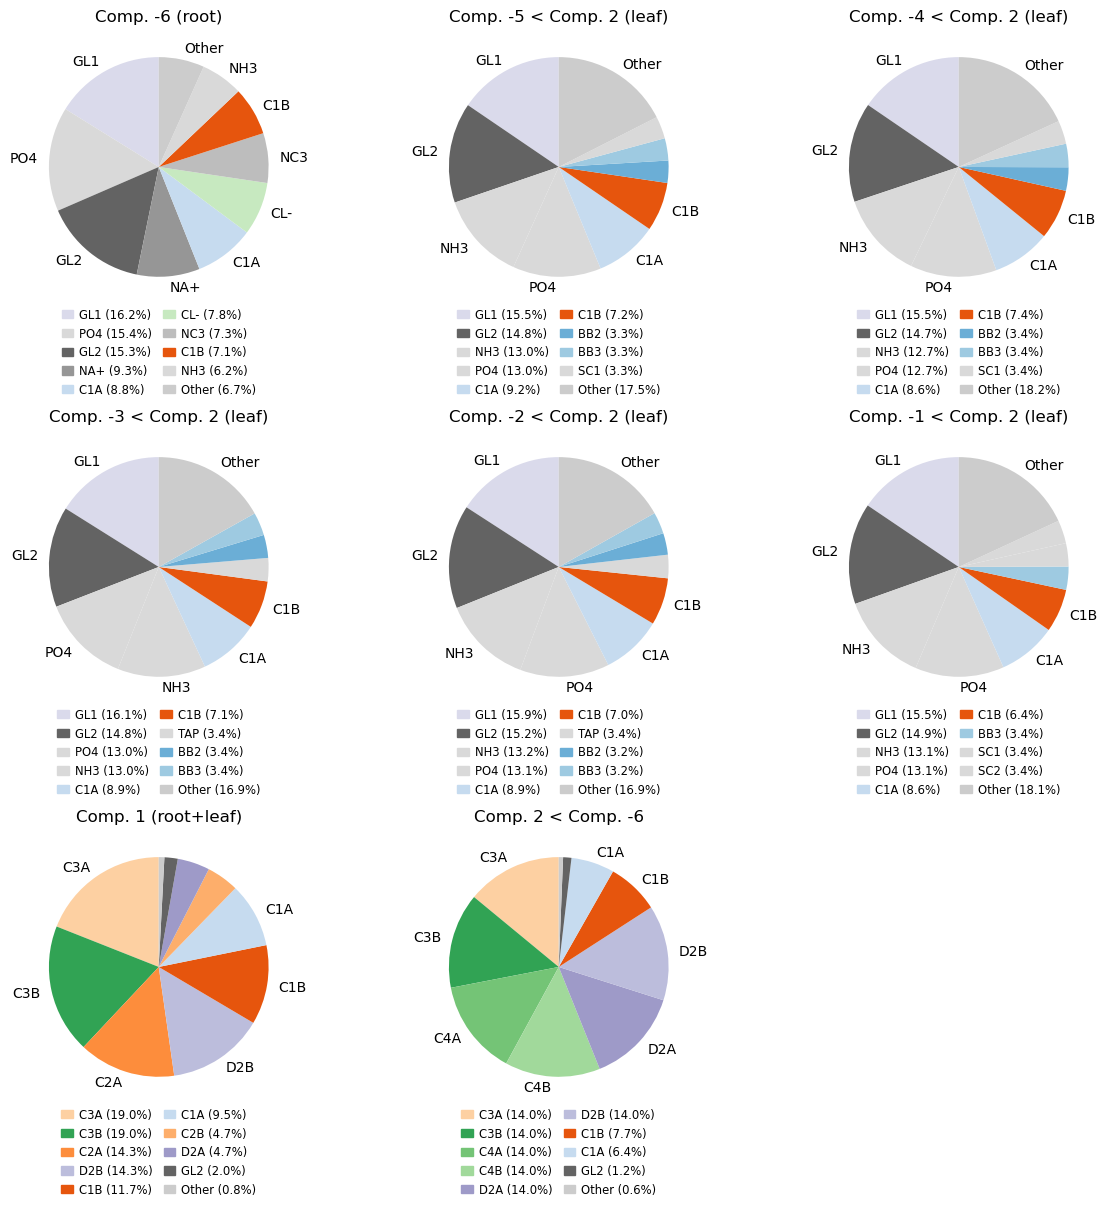

In [9]:
composition, fig, axs = cl.analyze_composition(containment, mode='names')

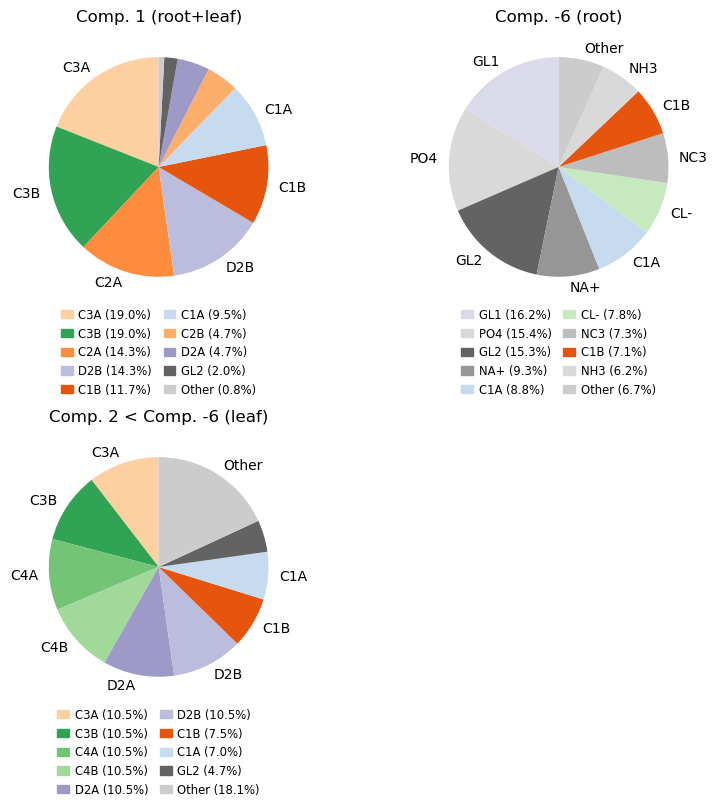

In [10]:
# We can also analyze the compositions of the filtered containment view
composition, fig, axs = cl.analyze_composition(containment_size_filtered, mode='names')

## Performing some hierarchical analysis
The goal is to select a random non_root and non-leaf container if there is one.
This is a rather arbitrary goal, but we hope it illustrates
how one can use a topological description to handle high
throughput data with noise. Quickly filtering interesting cases
which can be processed with more attention.

In [11]:
# Preparing the node sets for our selection
all_nodes = set(containment.voxel_containment.nodes)
root_nodes = set(containment.voxel_containment.root_nodes)
leaf_nodes = set(containment.voxel_containment.leaf_nodes)

# Select non-root and non-leaf nodes
container_nodes = list(all_nodes ^ (root_nodes | leaf_nodes))
# Shuffle the possible nodes for random selection
random.shuffle(container_nodes)
# Pick the first node in the shuffle list of possible container nodes
try:
    node = container_nodes[0]
    print(f'Selected non-root container: {node}')
except IndexError:
    print('No component satisfies the specified conditions.')

Selected non-root container: 2


In [12]:
# Get the atomgroup from the list of nodes.
visualize = False
if node is not None:
    container = containment.get_atomgroup_from_nodes([node], containment=True)
    print(f'Atomgroup with {len(container)} atoms.')
    # Write the atomgroup
    container.write('random_container.pdb')
    # Visualize with VMD
    if visualize:
        !{vmd} random_container.gro
else:
    raise ValueError('There are no non-root containers in the system.')

Atomgroup with 89893 atoms.


### Plotting the composition of the container and its contents
#### Counting the resnames in the atomgroup.atoms

In [13]:
# Make another view to only get the nodes downstream of the selected node
containment_nonroot_container = containment.node_view([node])
nodes = [node]

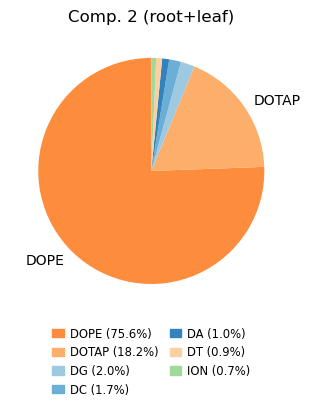

In [14]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='resnames')

#### Counting the names in the atomgroup.atoms

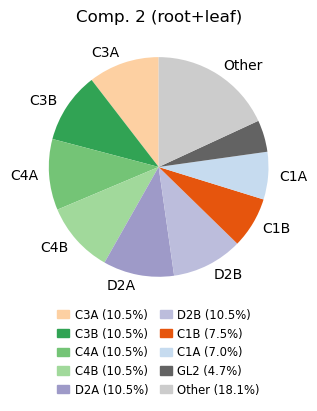

In [15]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='names')

In [16]:
# Demonstrating the power of Views!
print(containment.get_atomgroup_from_nodes([node]).__repr__())
print(containment)

print(containment_nonroot_container.get_atomgroup_from_nodes([node]).__repr__())
print(containment_nonroot_container)

original_nodes = [int(sub_node) for sub_node in containment_nonroot_container.voxel_containment.get_original_nodes(node)]
print(f'Original nodes merged into node {node}: {original_nodes}')

<AtomGroup with 67004 atoms>
Containment Graph with 8 components (component: nvoxels: rank):
├── [-6: 640302: 2]
│   └── [2: 58438: 0]
│       ├── [-2: 3048: 0]
│       ├── [-5: 6034: 0]
│       ├── [-4: 8547: 0]
│       ├── [-3: 2801: 0]
│       └── [-1: 2865: 0]
└── [1: 31261: 2]

<AtomGroup with 89893 atoms>
Containment Graph with 1 components (component: nvoxels: rank):
└── [2: 81733: 0]

Original nodes merged into node 2: [2, -2, -5, -4, -3, -1]


In [17]:
# Show the interactive widget plotting
cl.show_containment_with_composition(containment, max_display_items=1000, mode='resnames')